In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

%matplotlib inline

In [2]:
inpDir = os.path.join('..', '..', 'input')
moduleDir = 'machine_learning'
outDir = os.path.join('..', 'output')
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

EPOCHS = 20000 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

<Figure size 1500x900 with 0 Axes>

In [3]:
def fn_plot_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.4, edgecolor = 'b')  
    ax = axes[0]
    
    
    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)
    lossmin = hist_df[hist_df.columns[0]].min()    
    testmin = hist_df[hist_df.columns[2]].min()

    
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0], lossmin, testmin)
    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[0].capitalize())
    
    ax = axes[1]
    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP) 
    accmin = hist_df[hist_df.columns[1]].max()    
    testmin = hist_df[hist_df.columns[3]].max()    
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1], accmin, testmin) #text to plot    
    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    ax.set_xlabel("Epochs")    
    ax.set_ylabel(hist_df.columns[1].capitalize())    
    plt.tight_layout()

In [4]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLES, shuffle=True, noise=NOISE, random_state=RANDOM_STATE)

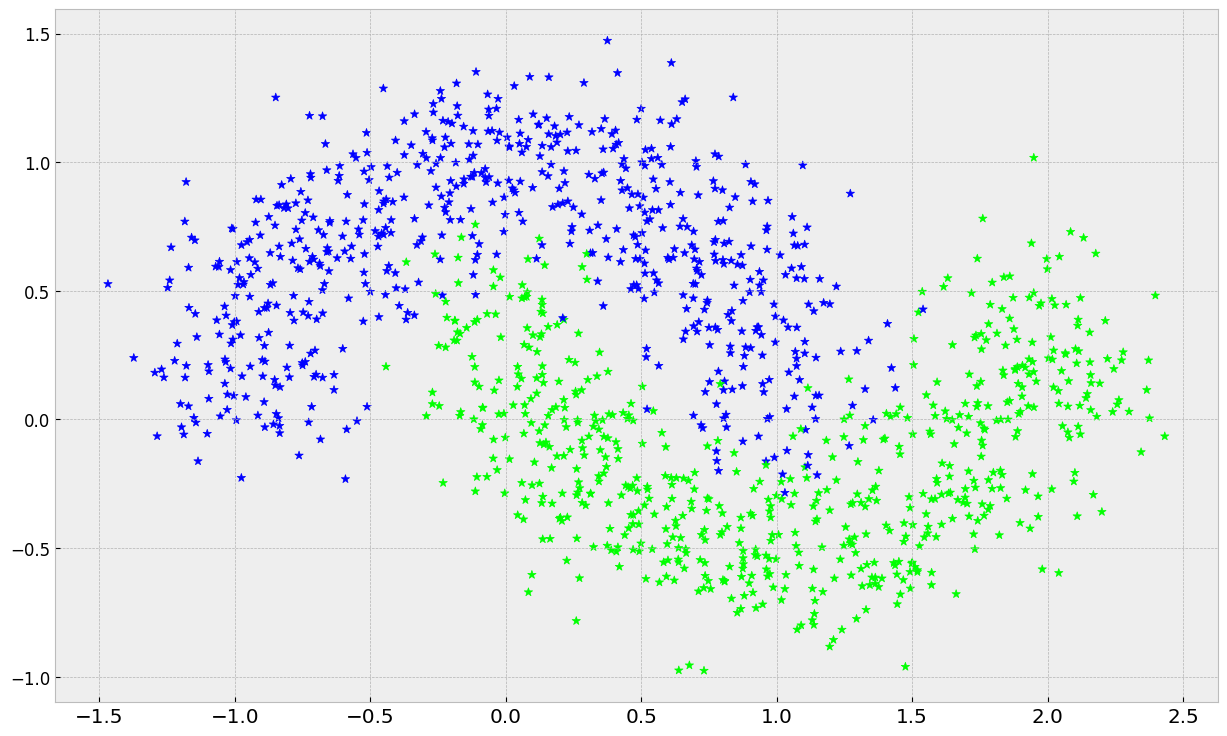

In [5]:
# Lets Plot the data
plt.scatter(X[:,0], X[:,1], s=40, c=y, marker='*', cmap=CMAP);

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE )
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024,) (256, 2) (256,)


In [7]:
def fn_sigmoid(z):
    return 1 / ( 1 + np.exp ( -z ) )

In [8]:
fn_sigmoid(np.array([-50., 0, 50.]))

array([1.92874985e-22, 5.00000000e-01, 1.00000000e+00])

In [9]:
def fn_tanh(z):
    return np.tanh(z)
def fn_tanh_prime(z):
    return 1.0-np.tanh(z)**2

In [10]:
fn_tanh(0.5)

0.46211715726000974

In [11]:
fn_tanh_prime(0.5)

0.7864477329659274

In [12]:
def fn_plot_decision_boundary(pred_func, X, y):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    h = 0.01
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [13]:
def calculate_loss(model, X, y):
    '''
    Args:
        model: dictionay object containing weights and biases
        X: Feature Matrix
        y: Labels array
    Returns:
        Average loss
    '''
    W1, b1, W2, b2 = model['W1'],model['b1'],model['W2'],model['b2']
    z1 = X.dot(W1) + b1 # Agg
    a1 = fn_tanh (z1) # Activation
    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)
    
    data_loss = -(y* np.log(a2)).sum()

    return 1./num_examples * data_loss

In [14]:
def predict(model, X):
    '''
     Args:
         model
         X: input features
    Returns:
        Predictions against the instances
         
    '''
    
    W1, b1, W2, b2 = model['W1'],model['b1'],model['W2'],model['b2']
    z1 = X.dot(W1) + b1 # Agg
    a1 = fn_tanh (z1) # Activation
    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)
    
    return a2>=0.5

In [15]:
def build_model(nn_hdim, X, y, alpha=ALPHA, epochs=EPOCHS):
    
    '''
        Args:
            nn_hdim: number of nodes in hidden layer
            X: np.ndarray, feature set
            y: np.ndarray, labels
    '''
    
    W1 = np.random.rand(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    W2 = np.random.rand(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    
    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))
    
    curr_loss = 0
    loss = []
    epoch = []
    
    for i in range(epochs):
        
        ###-------------------------###
        ###---Forward Propogation---###
        ###-------------------------###
        
        #layer 1:
        z1 = X.dot(W1) + b1 # Agg
        a1 = fn_tanh (z1) # Activation
        
        # Layer 2
        z2 = a1.dot(W2) + b2
        a2 = fn_sigmoid(z2)
        
        ###--------------------------###
        ###-----Back Propogation-----###
        ###--------------------------###   
        
        dz2 = a2 - y        
        dW2 = (a1.T).dot(dz2)
        assert (W2.shape == dW2.shape), 'Shape of W2 {} and shape of dW2 {}'.format(W2.shape, dW2.shape)
        db2 = np.sum(dz2, axis = 0, keepdims=True)        
        dz1 = dz2.dot(W2.T) * fn_tanh_prime(z1)        
        dW1 = (X.T).dot(dz1)
        assert (W1.shape == dW1.shape), 'Shape of W1 {} and shape of dW1 {}'.format(W1.shape, dW1.shape)
        db1 = np.sum(dz1, axis = 0, keepdims=True)
        
        ###--------------------------###
        ###-----Gradient Updates-----###
        ###--------------------------###
        
        W1 += -alpha * dW1 / num_examples
        W2 += -alpha * dW2 / num_examples
        b1 += -alpha * db1 / num_examples
        b2 += -alpha * db2 / num_examples
        
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if i%100 ==  0:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
            
        if i%1000 == 0:
            print ('loss after {} epochs : {}'.format(i,curr_loss))
    loss_hist['epoch'] =epoch
    loss_hist['loss'] = loss    
    
    return model

In [16]:
num_examples = len(X_train)
nn_input_dim = 2
nn_output_dim = 1

loss_hist = {}

y_train = y_train.reshape(-1,1)
y_train.shape

(1024, 1)

In [17]:
num_hidden = 4
nn_input_dim = X.shape[1]
nn_output_dim = 1
model = build_model(num_hidden, X_train, y_train)

loss after 0 epochs : 0.2975464893959424
loss after 1000 epochs : 0.14832772950569495
loss after 2000 epochs : 0.10529788127102664
loss after 3000 epochs : 0.07204699729379478
loss after 4000 epochs : 0.05118920643393722
loss after 5000 epochs : 0.04344262508762445
loss after 6000 epochs : 0.040706593731453536
loss after 7000 epochs : 0.039599350264121286
loss after 8000 epochs : 0.03909206778211763
loss after 9000 epochs : 0.03883557798643647
loss after 10000 epochs : 0.038693481591840134
loss after 11000 epochs : 0.03860581530334984
loss after 12000 epochs : 0.03854340193873192
loss after 13000 epochs : 0.03849049884233493
loss after 14000 epochs : 0.038437638557465514
loss after 15000 epochs : 0.03837894118033118
loss after 16000 epochs : 0.0383117793780513
loss after 17000 epochs : 0.038237074357530876
loss after 18000 epochs : 0.038158417443141635
loss after 19000 epochs : 0.038079885382219056


In [18]:
model

{'W1': array([[ 2.79041287,  2.44970483,  3.47220643,  2.91762332],
        [-1.55566921, -0.6463521 ,  2.15369115, -1.44829738]]),
 'b1': array([[-3.48402534,  1.50403154, -2.11980432,  1.25236184]]),
 'W2': array([[ 6.79076407],
        [ 3.17542826],
        [-6.69462207],
        [ 4.44760445]]),
 'b2': array([[-0.61156034]])}

In [19]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(y_train, y_pred))

Accuracy score on Train Data : 0.96875


In [20]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       522
           1       0.97      0.97      0.97       502

    accuracy                           0.97      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



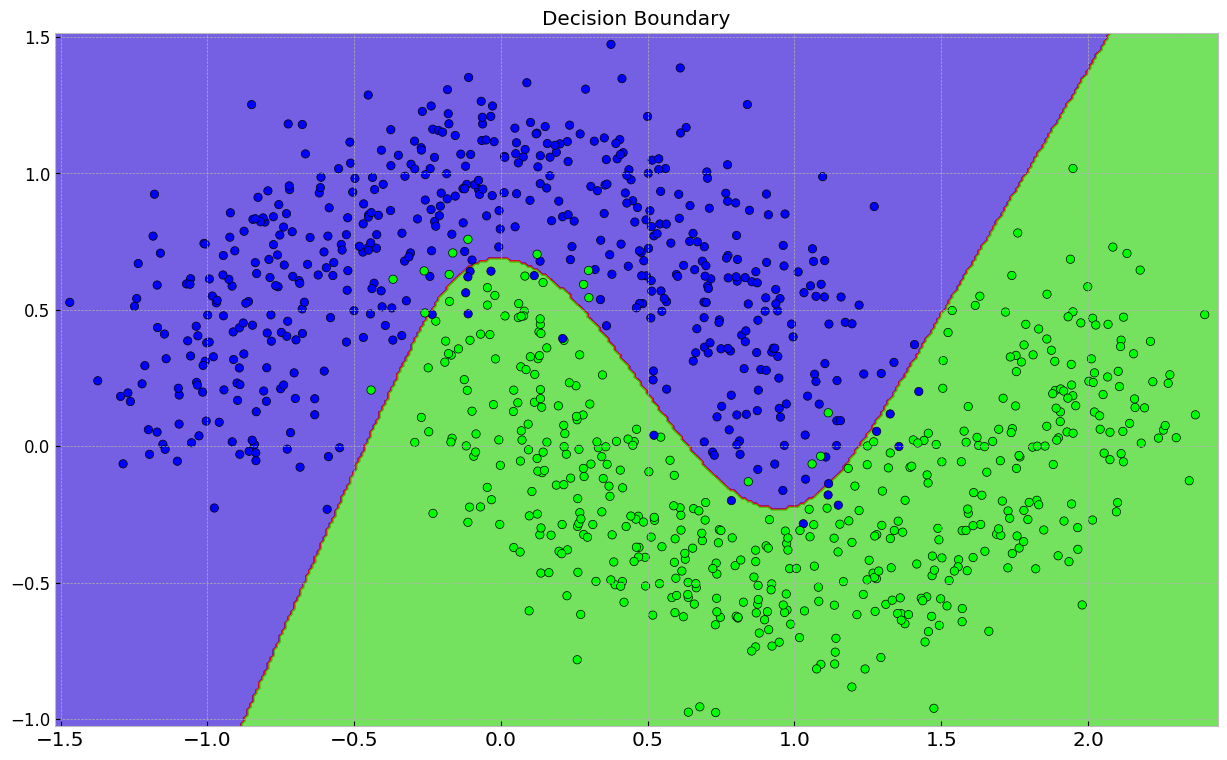

In [21]:
loss_df = pd.DataFrame(loss_hist)
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot
plt.title("Decision Boundary");

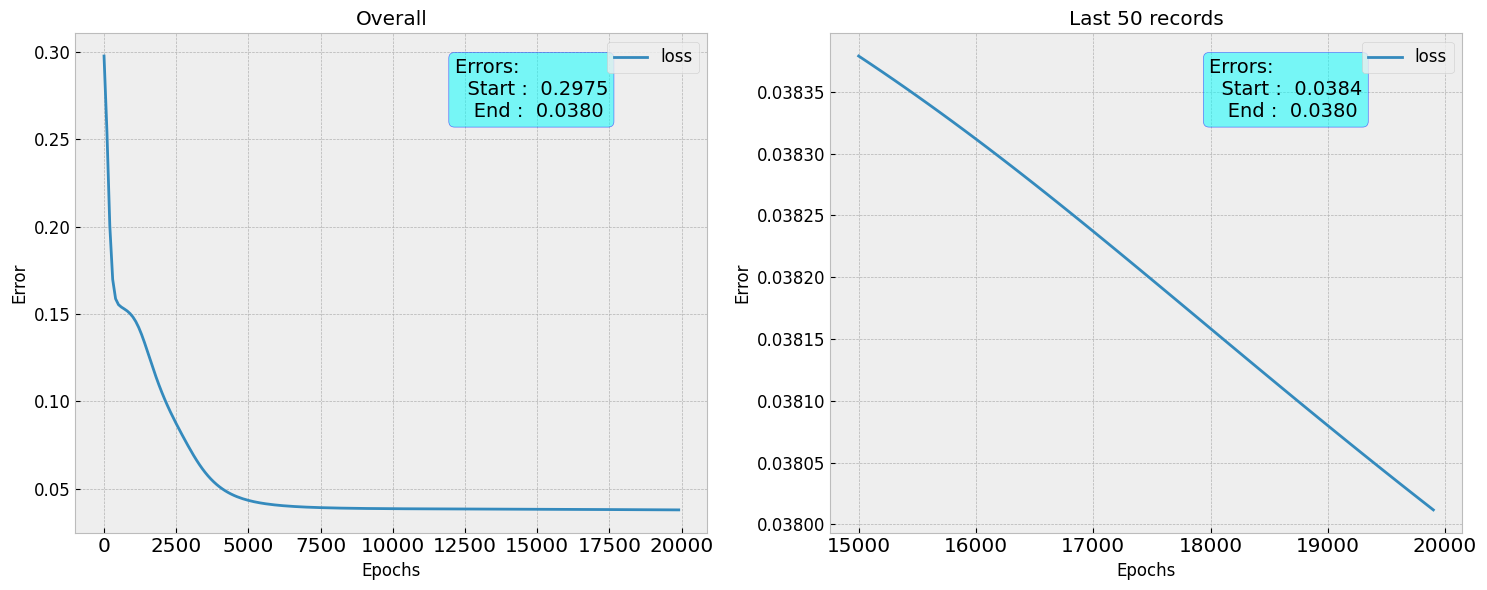

In [22]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))
l_range = 50
ax = axes[0]

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)
loss = loss_df['loss'].values


txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1])
props = dict(boxstyle='round', facecolor='cyan', alpha=0.5, edgecolor = 'b')
ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1])
props = dict(boxstyle='round', facecolor='cyan', alpha=0.5, edgecolor = 'b')

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))

plt.tight_layout()


In [23]:
y_pred = predict(model, X_test)
print('Accuracy score on Train Data :', accuracy_score(y_test, y_pred))
y_test.shape, y_pred.shape

Accuracy score on Train Data : 0.95703125


((256,), (256, 1))

In [24]:
cm  = confusion_matrix(y_test, y_pred)
cm

array([[113,   5],
       [  6, 132]])

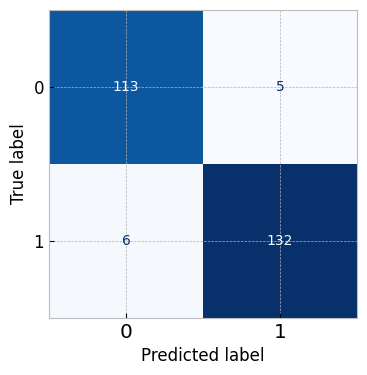

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize = (4,4))
disp.plot(ax = ax, cmap = 'Blues', colorbar=False)
plt.show();

In [26]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')

try:    
    tf.config.experimental.set_memory_growth(physical_devices[0], True)    
except:    
    print ('Invalid device or cannot modify virtual devices once initialized.')    
    pass

2023-01-28 17:06:47.061765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 17:06:47.193549: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-28 17:06:47.903704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpcap/intel/oneapi/vpl/2023.0.0/lib:/home/hpcap/intel/oneapi/tbb/2021.8.0/env/../

Invalid device or cannot modify virtual devices once initialized.


2023-01-28 17:06:48.413285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-28 17:06:48.413310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pankajgharde): /proc/driver/nvidia/version does not exist


In [34]:
krnl_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# Define sequential model with same size and activation functions
model = tf.keras.models.Sequential([tf.keras.layers.Dense(4, activation='tanh', kernel_initializer=krnl_init),
  tf.keras.layers.Dense(2, kernel_initializer=krnl_init)])

# Using cross entropy for loss calculations
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [35]:
model.compile(optimizer='Adam', loss=loss_fn, metrics=['accuracy'])

In [36]:
history = model.fit(X_train, y_train, validation_data = [X_test, y_test], epochs = 1000, verbose =2)

Epoch 1/1000
32/32 - 1s - loss: 0.8454 - accuracy: 0.2783 - val_loss: 0.8328 - val_accuracy: 0.2891 - 536ms/epoch - 17ms/step
Epoch 2/1000
32/32 - 0s - loss: 0.8001 - accuracy: 0.2930 - val_loss: 0.7892 - val_accuracy: 0.3242 - 59ms/epoch - 2ms/step
Epoch 3/1000
32/32 - 0s - loss: 0.7620 - accuracy: 0.3301 - val_loss: 0.7476 - val_accuracy: 0.3477 - 59ms/epoch - 2ms/step
Epoch 4/1000
32/32 - 0s - loss: 0.7251 - accuracy: 0.3965 - val_loss: 0.7091 - val_accuracy: 0.4336 - 60ms/epoch - 2ms/step
Epoch 5/1000
32/32 - 0s - loss: 0.6874 - accuracy: 0.5488 - val_loss: 0.6710 - val_accuracy: 0.6758 - 59ms/epoch - 2ms/step
Epoch 6/1000
32/32 - 0s - loss: 0.6500 - accuracy: 0.8125 - val_loss: 0.6304 - val_accuracy: 0.8750 - 58ms/epoch - 2ms/step
Epoch 7/1000
32/32 - 0s - loss: 0.6114 - accuracy: 0.8721 - val_loss: 0.5930 - val_accuracy: 0.8516 - 58ms/epoch - 2ms/step
Epoch 8/1000
32/32 - 0s - loss: 0.5751 - accuracy: 0.8428 - val_loss: 0.5567 - val_accuracy: 0.8398 - 56ms/epoch - 2ms/step
Epoch 

Epoch 67/1000
32/32 - 0s - loss: 0.3009 - accuracy: 0.8760 - val_loss: 0.2883 - val_accuracy: 0.8789 - 62ms/epoch - 2ms/step
Epoch 68/1000
32/32 - 0s - loss: 0.3009 - accuracy: 0.8760 - val_loss: 0.2881 - val_accuracy: 0.8789 - 57ms/epoch - 2ms/step
Epoch 69/1000
32/32 - 0s - loss: 0.3010 - accuracy: 0.8760 - val_loss: 0.2881 - val_accuracy: 0.8789 - 59ms/epoch - 2ms/step
Epoch 70/1000
32/32 - 0s - loss: 0.3009 - accuracy: 0.8760 - val_loss: 0.2879 - val_accuracy: 0.8789 - 57ms/epoch - 2ms/step
Epoch 71/1000
32/32 - 0s - loss: 0.3010 - accuracy: 0.8770 - val_loss: 0.2879 - val_accuracy: 0.8789 - 59ms/epoch - 2ms/step
Epoch 72/1000
32/32 - 0s - loss: 0.3008 - accuracy: 0.8760 - val_loss: 0.2880 - val_accuracy: 0.8789 - 58ms/epoch - 2ms/step
Epoch 73/1000
32/32 - 0s - loss: 0.3009 - accuracy: 0.8760 - val_loss: 0.2881 - val_accuracy: 0.8789 - 57ms/epoch - 2ms/step
Epoch 74/1000
32/32 - 0s - loss: 0.3007 - accuracy: 0.8750 - val_loss: 0.2877 - val_accuracy: 0.8789 - 57ms/epoch - 2ms/step


Epoch 133/1000
32/32 - 0s - loss: 0.2995 - accuracy: 0.8750 - val_loss: 0.2864 - val_accuracy: 0.8789 - 60ms/epoch - 2ms/step
Epoch 134/1000
32/32 - 0s - loss: 0.2993 - accuracy: 0.8750 - val_loss: 0.2860 - val_accuracy: 0.8789 - 60ms/epoch - 2ms/step
Epoch 135/1000
32/32 - 0s - loss: 0.2993 - accuracy: 0.8770 - val_loss: 0.2862 - val_accuracy: 0.8789 - 61ms/epoch - 2ms/step
Epoch 136/1000
32/32 - 0s - loss: 0.2993 - accuracy: 0.8760 - val_loss: 0.2863 - val_accuracy: 0.8789 - 59ms/epoch - 2ms/step
Epoch 137/1000
32/32 - 0s - loss: 0.2992 - accuracy: 0.8770 - val_loss: 0.2862 - val_accuracy: 0.8789 - 57ms/epoch - 2ms/step
Epoch 138/1000
32/32 - 0s - loss: 0.2994 - accuracy: 0.8760 - val_loss: 0.2860 - val_accuracy: 0.8789 - 60ms/epoch - 2ms/step
Epoch 139/1000
32/32 - 0s - loss: 0.2995 - accuracy: 0.8750 - val_loss: 0.2864 - val_accuracy: 0.8789 - 61ms/epoch - 2ms/step
Epoch 140/1000
32/32 - 0s - loss: 0.2992 - accuracy: 0.8770 - val_loss: 0.2859 - val_accuracy: 0.8789 - 60ms/epoch - 2

32/32 - 0s - loss: 0.2976 - accuracy: 0.8760 - val_loss: 0.2842 - val_accuracy: 0.8789 - 61ms/epoch - 2ms/step
Epoch 199/1000
32/32 - 0s - loss: 0.2973 - accuracy: 0.8789 - val_loss: 0.2839 - val_accuracy: 0.8789 - 59ms/epoch - 2ms/step
Epoch 200/1000
32/32 - 0s - loss: 0.2973 - accuracy: 0.8789 - val_loss: 0.2842 - val_accuracy: 0.8828 - 58ms/epoch - 2ms/step
Epoch 201/1000
32/32 - 0s - loss: 0.2972 - accuracy: 0.8789 - val_loss: 0.2837 - val_accuracy: 0.8789 - 57ms/epoch - 2ms/step
Epoch 202/1000
32/32 - 0s - loss: 0.2972 - accuracy: 0.8779 - val_loss: 0.2838 - val_accuracy: 0.8789 - 60ms/epoch - 2ms/step
Epoch 203/1000
32/32 - 0s - loss: 0.2971 - accuracy: 0.8770 - val_loss: 0.2833 - val_accuracy: 0.8789 - 62ms/epoch - 2ms/step
Epoch 204/1000
32/32 - 0s - loss: 0.2969 - accuracy: 0.8779 - val_loss: 0.2835 - val_accuracy: 0.8789 - 58ms/epoch - 2ms/step
Epoch 205/1000
32/32 - 0s - loss: 0.2970 - accuracy: 0.8779 - val_loss: 0.2834 - val_accuracy: 0.8789 - 60ms/epoch - 2ms/step
Epoch 2

Epoch 264/1000
32/32 - 0s - loss: 0.2765 - accuracy: 0.8887 - val_loss: 0.2607 - val_accuracy: 0.9023 - 60ms/epoch - 2ms/step
Epoch 265/1000
32/32 - 0s - loss: 0.2757 - accuracy: 0.8906 - val_loss: 0.2593 - val_accuracy: 0.9023 - 59ms/epoch - 2ms/step
Epoch 266/1000
32/32 - 0s - loss: 0.2744 - accuracy: 0.8896 - val_loss: 0.2586 - val_accuracy: 0.9062 - 65ms/epoch - 2ms/step
Epoch 267/1000
32/32 - 0s - loss: 0.2735 - accuracy: 0.8896 - val_loss: 0.2573 - val_accuracy: 0.9023 - 58ms/epoch - 2ms/step
Epoch 268/1000
32/32 - 0s - loss: 0.2723 - accuracy: 0.8896 - val_loss: 0.2563 - val_accuracy: 0.9062 - 60ms/epoch - 2ms/step
Epoch 269/1000
32/32 - 0s - loss: 0.2710 - accuracy: 0.8896 - val_loss: 0.2553 - val_accuracy: 0.9023 - 60ms/epoch - 2ms/step
Epoch 270/1000
32/32 - 0s - loss: 0.2696 - accuracy: 0.8896 - val_loss: 0.2540 - val_accuracy: 0.9023 - 59ms/epoch - 2ms/step
Epoch 271/1000
32/32 - 0s - loss: 0.2687 - accuracy: 0.8896 - val_loss: 0.2526 - val_accuracy: 0.9023 - 57ms/epoch - 2

32/32 - 0s - loss: 0.1860 - accuracy: 0.9238 - val_loss: 0.1758 - val_accuracy: 0.9297 - 59ms/epoch - 2ms/step
Epoch 330/1000
32/32 - 0s - loss: 0.1847 - accuracy: 0.9238 - val_loss: 0.1745 - val_accuracy: 0.9297 - 61ms/epoch - 2ms/step
Epoch 331/1000
32/32 - 0s - loss: 0.1837 - accuracy: 0.9238 - val_loss: 0.1737 - val_accuracy: 0.9297 - 61ms/epoch - 2ms/step
Epoch 332/1000
32/32 - 0s - loss: 0.1826 - accuracy: 0.9238 - val_loss: 0.1724 - val_accuracy: 0.9297 - 60ms/epoch - 2ms/step
Epoch 333/1000
32/32 - 0s - loss: 0.1814 - accuracy: 0.9248 - val_loss: 0.1717 - val_accuracy: 0.9297 - 60ms/epoch - 2ms/step
Epoch 334/1000
32/32 - 0s - loss: 0.1805 - accuracy: 0.9258 - val_loss: 0.1709 - val_accuracy: 0.9336 - 63ms/epoch - 2ms/step
Epoch 335/1000
32/32 - 0s - loss: 0.1794 - accuracy: 0.9258 - val_loss: 0.1698 - val_accuracy: 0.9297 - 62ms/epoch - 2ms/step
Epoch 336/1000
32/32 - 0s - loss: 0.1784 - accuracy: 0.9258 - val_loss: 0.1687 - val_accuracy: 0.9297 - 61ms/epoch - 2ms/step
Epoch 3

Epoch 395/1000
32/32 - 0s - loss: 0.1368 - accuracy: 0.9531 - val_loss: 0.1335 - val_accuracy: 0.9570 - 62ms/epoch - 2ms/step
Epoch 396/1000
32/32 - 0s - loss: 0.1362 - accuracy: 0.9531 - val_loss: 0.1332 - val_accuracy: 0.9570 - 58ms/epoch - 2ms/step
Epoch 397/1000
32/32 - 0s - loss: 0.1357 - accuracy: 0.9521 - val_loss: 0.1328 - val_accuracy: 0.9570 - 58ms/epoch - 2ms/step
Epoch 398/1000
32/32 - 0s - loss: 0.1352 - accuracy: 0.9541 - val_loss: 0.1322 - val_accuracy: 0.9570 - 62ms/epoch - 2ms/step
Epoch 399/1000
32/32 - 0s - loss: 0.1350 - accuracy: 0.9531 - val_loss: 0.1322 - val_accuracy: 0.9531 - 60ms/epoch - 2ms/step
Epoch 400/1000
32/32 - 0s - loss: 0.1344 - accuracy: 0.9531 - val_loss: 0.1313 - val_accuracy: 0.9570 - 59ms/epoch - 2ms/step
Epoch 401/1000
32/32 - 0s - loss: 0.1340 - accuracy: 0.9521 - val_loss: 0.1312 - val_accuracy: 0.9570 - 59ms/epoch - 2ms/step
Epoch 402/1000
32/32 - 0s - loss: 0.1334 - accuracy: 0.9531 - val_loss: 0.1309 - val_accuracy: 0.9570 - 59ms/epoch - 2

32/32 - 0s - loss: 0.1152 - accuracy: 0.9629 - val_loss: 0.1164 - val_accuracy: 0.9609 - 63ms/epoch - 2ms/step
Epoch 461/1000
32/32 - 0s - loss: 0.1148 - accuracy: 0.9619 - val_loss: 0.1160 - val_accuracy: 0.9570 - 61ms/epoch - 2ms/step
Epoch 462/1000
32/32 - 0s - loss: 0.1146 - accuracy: 0.9629 - val_loss: 0.1159 - val_accuracy: 0.9570 - 61ms/epoch - 2ms/step
Epoch 463/1000
32/32 - 0s - loss: 0.1146 - accuracy: 0.9639 - val_loss: 0.1157 - val_accuracy: 0.9609 - 63ms/epoch - 2ms/step
Epoch 464/1000
32/32 - 0s - loss: 0.1141 - accuracy: 0.9629 - val_loss: 0.1156 - val_accuracy: 0.9609 - 60ms/epoch - 2ms/step
Epoch 465/1000
32/32 - 0s - loss: 0.1139 - accuracy: 0.9619 - val_loss: 0.1154 - val_accuracy: 0.9570 - 61ms/epoch - 2ms/step
Epoch 466/1000
32/32 - 0s - loss: 0.1140 - accuracy: 0.9619 - val_loss: 0.1151 - val_accuracy: 0.9570 - 59ms/epoch - 2ms/step
Epoch 467/1000
32/32 - 0s - loss: 0.1136 - accuracy: 0.9619 - val_loss: 0.1150 - val_accuracy: 0.9570 - 62ms/epoch - 2ms/step
Epoch 4

Epoch 526/1000
32/32 - 0s - loss: 0.1036 - accuracy: 0.9639 - val_loss: 0.1076 - val_accuracy: 0.9609 - 62ms/epoch - 2ms/step
Epoch 527/1000
32/32 - 0s - loss: 0.1034 - accuracy: 0.9639 - val_loss: 0.1075 - val_accuracy: 0.9609 - 60ms/epoch - 2ms/step
Epoch 528/1000
32/32 - 0s - loss: 0.1033 - accuracy: 0.9629 - val_loss: 0.1076 - val_accuracy: 0.9570 - 63ms/epoch - 2ms/step
Epoch 529/1000
32/32 - 0s - loss: 0.1033 - accuracy: 0.9639 - val_loss: 0.1074 - val_accuracy: 0.9609 - 63ms/epoch - 2ms/step
Epoch 530/1000
32/32 - 0s - loss: 0.1030 - accuracy: 0.9639 - val_loss: 0.1072 - val_accuracy: 0.9570 - 62ms/epoch - 2ms/step
Epoch 531/1000
32/32 - 0s - loss: 0.1029 - accuracy: 0.9639 - val_loss: 0.1071 - val_accuracy: 0.9609 - 61ms/epoch - 2ms/step
Epoch 532/1000
32/32 - 0s - loss: 0.1029 - accuracy: 0.9639 - val_loss: 0.1071 - val_accuracy: 0.9609 - 61ms/epoch - 2ms/step
Epoch 533/1000
32/32 - 0s - loss: 0.1026 - accuracy: 0.9639 - val_loss: 0.1070 - val_accuracy: 0.9609 - 61ms/epoch - 2

32/32 - 0s - loss: 0.0970 - accuracy: 0.9639 - val_loss: 0.1029 - val_accuracy: 0.9648 - 59ms/epoch - 2ms/step
Epoch 592/1000
32/32 - 0s - loss: 0.0968 - accuracy: 0.9658 - val_loss: 0.1029 - val_accuracy: 0.9648 - 60ms/epoch - 2ms/step
Epoch 593/1000
32/32 - 0s - loss: 0.0967 - accuracy: 0.9648 - val_loss: 0.1030 - val_accuracy: 0.9648 - 62ms/epoch - 2ms/step
Epoch 594/1000
32/32 - 0s - loss: 0.0968 - accuracy: 0.9658 - val_loss: 0.1028 - val_accuracy: 0.9648 - 61ms/epoch - 2ms/step
Epoch 595/1000
32/32 - 0s - loss: 0.0970 - accuracy: 0.9648 - val_loss: 0.1029 - val_accuracy: 0.9648 - 62ms/epoch - 2ms/step
Epoch 596/1000
32/32 - 0s - loss: 0.0967 - accuracy: 0.9648 - val_loss: 0.1028 - val_accuracy: 0.9609 - 61ms/epoch - 2ms/step
Epoch 597/1000
32/32 - 0s - loss: 0.0969 - accuracy: 0.9668 - val_loss: 0.1027 - val_accuracy: 0.9609 - 61ms/epoch - 2ms/step
Epoch 598/1000
32/32 - 0s - loss: 0.0965 - accuracy: 0.9668 - val_loss: 0.1028 - val_accuracy: 0.9609 - 61ms/epoch - 2ms/step
Epoch 5

Epoch 657/1000
32/32 - 0s - loss: 0.0927 - accuracy: 0.9648 - val_loss: 0.1004 - val_accuracy: 0.9648 - 61ms/epoch - 2ms/step
Epoch 658/1000
32/32 - 0s - loss: 0.0927 - accuracy: 0.9639 - val_loss: 0.1004 - val_accuracy: 0.9648 - 61ms/epoch - 2ms/step
Epoch 659/1000
32/32 - 0s - loss: 0.0925 - accuracy: 0.9648 - val_loss: 0.1003 - val_accuracy: 0.9648 - 61ms/epoch - 2ms/step
Epoch 660/1000
32/32 - 0s - loss: 0.0926 - accuracy: 0.9648 - val_loss: 0.1003 - val_accuracy: 0.9648 - 64ms/epoch - 2ms/step
Epoch 661/1000
32/32 - 0s - loss: 0.0924 - accuracy: 0.9658 - val_loss: 0.1004 - val_accuracy: 0.9648 - 59ms/epoch - 2ms/step
Epoch 662/1000
32/32 - 0s - loss: 0.0927 - accuracy: 0.9658 - val_loss: 0.1005 - val_accuracy: 0.9688 - 62ms/epoch - 2ms/step
Epoch 663/1000
32/32 - 0s - loss: 0.0923 - accuracy: 0.9658 - val_loss: 0.1001 - val_accuracy: 0.9648 - 60ms/epoch - 2ms/step
Epoch 664/1000
32/32 - 0s - loss: 0.0925 - accuracy: 0.9658 - val_loss: 0.1002 - val_accuracy: 0.9648 - 60ms/epoch - 2

32/32 - 0s - loss: 0.0900 - accuracy: 0.9658 - val_loss: 0.0988 - val_accuracy: 0.9648 - 58ms/epoch - 2ms/step
Epoch 723/1000
32/32 - 0s - loss: 0.0900 - accuracy: 0.9668 - val_loss: 0.0989 - val_accuracy: 0.9688 - 60ms/epoch - 2ms/step
Epoch 724/1000
32/32 - 0s - loss: 0.0898 - accuracy: 0.9678 - val_loss: 0.0990 - val_accuracy: 0.9648 - 64ms/epoch - 2ms/step
Epoch 725/1000
32/32 - 0s - loss: 0.0902 - accuracy: 0.9648 - val_loss: 0.0988 - val_accuracy: 0.9648 - 59ms/epoch - 2ms/step
Epoch 726/1000
32/32 - 0s - loss: 0.0896 - accuracy: 0.9668 - val_loss: 0.0989 - val_accuracy: 0.9648 - 61ms/epoch - 2ms/step
Epoch 727/1000
32/32 - 0s - loss: 0.0896 - accuracy: 0.9668 - val_loss: 0.0988 - val_accuracy: 0.9688 - 61ms/epoch - 2ms/step
Epoch 728/1000
32/32 - 0s - loss: 0.0896 - accuracy: 0.9688 - val_loss: 0.0989 - val_accuracy: 0.9648 - 60ms/epoch - 2ms/step
Epoch 729/1000
32/32 - 0s - loss: 0.0896 - accuracy: 0.9668 - val_loss: 0.0988 - val_accuracy: 0.9688 - 60ms/epoch - 2ms/step
Epoch 7

Epoch 788/1000
32/32 - 0s - loss: 0.0887 - accuracy: 0.9678 - val_loss: 0.0982 - val_accuracy: 0.9648 - 68ms/epoch - 2ms/step
Epoch 789/1000
32/32 - 0s - loss: 0.0878 - accuracy: 0.9668 - val_loss: 0.0979 - val_accuracy: 0.9688 - 61ms/epoch - 2ms/step
Epoch 790/1000
32/32 - 0s - loss: 0.0877 - accuracy: 0.9668 - val_loss: 0.0978 - val_accuracy: 0.9648 - 61ms/epoch - 2ms/step
Epoch 791/1000
32/32 - 0s - loss: 0.0877 - accuracy: 0.9688 - val_loss: 0.0980 - val_accuracy: 0.9648 - 63ms/epoch - 2ms/step
Epoch 792/1000
32/32 - 0s - loss: 0.0881 - accuracy: 0.9658 - val_loss: 0.0980 - val_accuracy: 0.9648 - 64ms/epoch - 2ms/step
Epoch 793/1000
32/32 - 0s - loss: 0.0880 - accuracy: 0.9697 - val_loss: 0.0982 - val_accuracy: 0.9648 - 59ms/epoch - 2ms/step
Epoch 794/1000
32/32 - 0s - loss: 0.0880 - accuracy: 0.9688 - val_loss: 0.0979 - val_accuracy: 0.9688 - 60ms/epoch - 2ms/step
Epoch 795/1000
32/32 - 0s - loss: 0.0876 - accuracy: 0.9668 - val_loss: 0.0980 - val_accuracy: 0.9648 - 61ms/epoch - 2

32/32 - 0s - loss: 0.0867 - accuracy: 0.9678 - val_loss: 0.0974 - val_accuracy: 0.9648 - 61ms/epoch - 2ms/step
Epoch 854/1000
32/32 - 0s - loss: 0.0865 - accuracy: 0.9688 - val_loss: 0.0976 - val_accuracy: 0.9648 - 62ms/epoch - 2ms/step
Epoch 855/1000
32/32 - 0s - loss: 0.0863 - accuracy: 0.9688 - val_loss: 0.0976 - val_accuracy: 0.9648 - 61ms/epoch - 2ms/step
Epoch 856/1000
32/32 - 0s - loss: 0.0864 - accuracy: 0.9688 - val_loss: 0.0977 - val_accuracy: 0.9648 - 62ms/epoch - 2ms/step
Epoch 857/1000
32/32 - 0s - loss: 0.0865 - accuracy: 0.9678 - val_loss: 0.0975 - val_accuracy: 0.9648 - 63ms/epoch - 2ms/step
Epoch 858/1000
32/32 - 0s - loss: 0.0862 - accuracy: 0.9688 - val_loss: 0.0977 - val_accuracy: 0.9648 - 63ms/epoch - 2ms/step
Epoch 859/1000
32/32 - 0s - loss: 0.0861 - accuracy: 0.9688 - val_loss: 0.0975 - val_accuracy: 0.9648 - 59ms/epoch - 2ms/step
Epoch 860/1000
32/32 - 0s - loss: 0.0862 - accuracy: 0.9688 - val_loss: 0.0975 - val_accuracy: 0.9648 - 62ms/epoch - 2ms/step
Epoch 8

Epoch 919/1000
32/32 - 0s - loss: 0.0851 - accuracy: 0.9688 - val_loss: 0.0973 - val_accuracy: 0.9570 - 61ms/epoch - 2ms/step
Epoch 920/1000
32/32 - 0s - loss: 0.0854 - accuracy: 0.9688 - val_loss: 0.0974 - val_accuracy: 0.9570 - 61ms/epoch - 2ms/step
Epoch 921/1000
32/32 - 0s - loss: 0.0852 - accuracy: 0.9678 - val_loss: 0.0970 - val_accuracy: 0.9648 - 62ms/epoch - 2ms/step
Epoch 922/1000
32/32 - 0s - loss: 0.0857 - accuracy: 0.9697 - val_loss: 0.0973 - val_accuracy: 0.9648 - 63ms/epoch - 2ms/step
Epoch 923/1000
32/32 - 0s - loss: 0.0855 - accuracy: 0.9658 - val_loss: 0.0970 - val_accuracy: 0.9648 - 59ms/epoch - 2ms/step
Epoch 924/1000
32/32 - 0s - loss: 0.0850 - accuracy: 0.9688 - val_loss: 0.0973 - val_accuracy: 0.9570 - 61ms/epoch - 2ms/step
Epoch 925/1000
32/32 - 0s - loss: 0.0852 - accuracy: 0.9688 - val_loss: 0.0974 - val_accuracy: 0.9570 - 60ms/epoch - 2ms/step
Epoch 926/1000
32/32 - 0s - loss: 0.0851 - accuracy: 0.9688 - val_loss: 0.0974 - val_accuracy: 0.9648 - 58ms/epoch - 2

32/32 - 0s - loss: 0.0843 - accuracy: 0.9668 - val_loss: 0.0974 - val_accuracy: 0.9609 - 63ms/epoch - 2ms/step
Epoch 985/1000
32/32 - 0s - loss: 0.0841 - accuracy: 0.9688 - val_loss: 0.0972 - val_accuracy: 0.9609 - 58ms/epoch - 2ms/step
Epoch 986/1000
32/32 - 0s - loss: 0.0842 - accuracy: 0.9678 - val_loss: 0.0969 - val_accuracy: 0.9648 - 62ms/epoch - 2ms/step
Epoch 987/1000
32/32 - 0s - loss: 0.0843 - accuracy: 0.9688 - val_loss: 0.0969 - val_accuracy: 0.9648 - 60ms/epoch - 2ms/step
Epoch 988/1000
32/32 - 0s - loss: 0.0844 - accuracy: 0.9668 - val_loss: 0.0971 - val_accuracy: 0.9648 - 62ms/epoch - 2ms/step
Epoch 989/1000
32/32 - 0s - loss: 0.0841 - accuracy: 0.9688 - val_loss: 0.0972 - val_accuracy: 0.9609 - 60ms/epoch - 2ms/step
Epoch 990/1000
32/32 - 0s - loss: 0.0842 - accuracy: 0.9688 - val_loss: 0.0973 - val_accuracy: 0.9609 - 62ms/epoch - 2ms/step
Epoch 991/1000
32/32 - 0s - loss: 0.0851 - accuracy: 0.9668 - val_loss: 0.0967 - val_accuracy: 0.9648 - 63ms/epoch - 2ms/step
Epoch 9

In [30]:
model.evaluate(X_test,  y_test, verbose = 2 )

8/8 - 0s - loss: 0.0973 - accuracy: 0.9609 - 28ms/epoch - 4ms/step


[0.09734218567609787, 0.9609375]

In [37]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [38]:
y_pred = probability_model(X_test).numpy().argmax(axis = 1)
print('Accuracy score on Test Data :', accuracy_score(y_test, y_pred))

Accuracy score on Test Data : 0.95703125


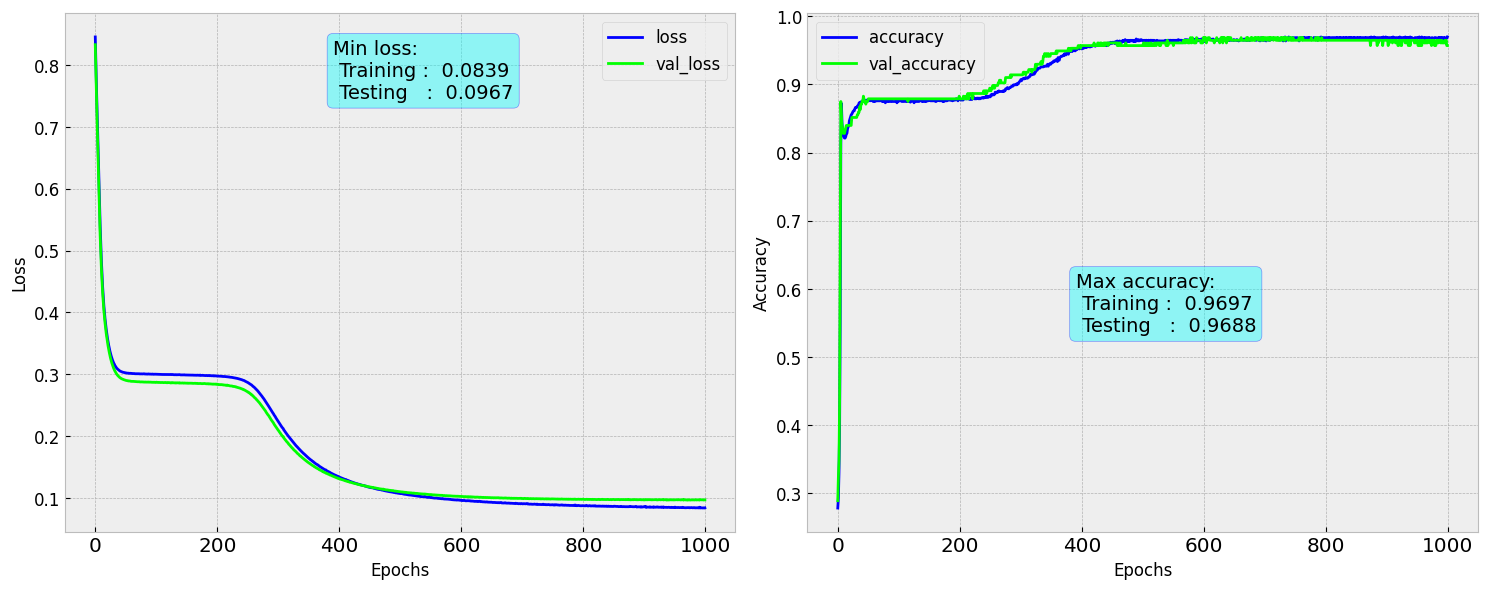

In [39]:
res_df = pd.DataFrame(history.history)
fn_plot_hist(res_df)